# 케라스를 이용한 학습 시각화
 - 지난 번에는 케라스를 사용했을 경우 학습이 제대로 이뤄지지 않았던 것을 확인할 수 있었습니다. 그 이유를 생각해봤는데 기존 매개변수를 초기화하는 과정에서 텐서플로우의 경우에는 tf.truncated_normal(shape, stddev=0.01)를 이용해 오차역전법이 잘 작동하도록 조정하였는데 케라스에서느 아무것도 지정해준게 없었습니다. 따라서 케라스에서 모델을 만들 때도 절단정규분포를 이용하면 학습이 잘 될 것이라 생각합니다.

In [1]:
# keras 모델을 만드는데 필요한 라이브러리들
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
from keras.layers.core import Dropout

Using TensorFlow backend.


In [2]:
# MNIST 데이터 셋, 데이터를 섞고 분류할 함수 불러오기
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf

mnist = datasets.fetch_mldata('MNIST original', data_home='.')

D:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)
D:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
# MNIST 데이터 전처리
n = len(mnist.data)
N = 10000
indices = np.random.permutation(range(n))[:N]
X = mnist.data[indices]
y = mnist.target[indices]
Y = np.eye(10)[y.astype(int)]

N_validation = 4000

# train, test 분류
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8)
# train데이터에서 validation 분류
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size = N_validation)

In [4]:
n_in = len(X[0])
n_hiddens = [200, 200, 200]
n_out = len(Y[0])
activation = 'relu'
p_keep = 0.5

from keras import backend as K

def weight_variable(shape, dtype=None):
    return K.truncated_normal(shape, stddev=0.01)
# numpy를 이용해도 됨.
# return np.random.normal(scale=0.01, size=shape) 단, 이때는 절단정규분포가 아닌 일반적인 정규분포입니다.

model = Sequential()
for i, input_dim in enumerate(([n_in] + n_hiddens)[:-1]):
    model.add(Dense(n_hiddens[i], input_dim=input_dim, kernel_initializer=weight_variable))
    model.add(Activation(activation))
    model.add(Dropout(p_keep))
    
model.add(Dense(n_out, kernel_initializer=weight_variable))
# 직접 함수로 절단정규분포를 정의할 수 있지만 처음부터 from keras.initializer import TruncatedNodrmal로 함수를 가져올 수 있습니다.
# model.add(Dense(n_out,, kernel_initializer=TruncatedNormal(stddev=0.01)))
model.add(Activation('softmax'))

In [5]:
model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=0.01), metrics=['accuracy'])

epochs = 50
batch_size = 200

hist = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_validation, Y_validation))


Train on 4000 samples, validate on 4000 samples
Epoch 1/50
4000/4000 [==============================] - 1s 322us/step - loss: 2.3010 - accuracy: 0.0990 - val_loss: 2.2944 - val_accuracy: 0.1303
Epoch 2/50
4000/4000 [==============================] - 1s 201us/step - loss: 2.2907 - accuracy: 0.1353 - val_loss: 2.2789 - val_accuracy: 0.1203
Epoch 3/50
4000/4000 [==============================] - 1s 207us/step - loss: 2.2666 - accuracy: 0.1417 - val_loss: 2.2362 - val_accuracy: 0.1040
Epoch 4/50
4000/4000 [==============================] - 1s 182us/step - loss: 2.2024 - accuracy: 0.1523 - val_loss: 2.1096 - val_accuracy: 0.2800
Epoch 5/50
4000/4000 [==============================] - 1s 172us/step - loss: 2.0425 - accuracy: 0.2835 - val_loss: 1.8176 - val_accuracy: 0.4810
Epoch 6/50
4000/4000 [==============================] - 1s 201us/step - loss: 1.6882 - accuracy: 0.4308 - val_loss: 1.2725 - val_accuracy: 0.5782
Epoch 7/50
4000/4000 [==============================] - 1s 169us/step - los

In [6]:
loss_and_metrics = model.evaluate(X_test, Y_test)

2000/2000 [==============================] - 0s 141us/step


In [7]:
print(loss_and_metrics)

[0.22123635470867156, 0.9419999718666077]


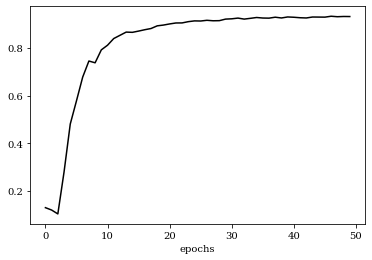

In [9]:
import matplotlib.pyplot as plt

val_acc = hist.history['val_accuracy']
plt.rc('font', family='serif')
fig = plt.figure()
plt.plot(range(epochs), val_acc, label='acc', color='black')
plt.xlabel('epochs')
plt.show()

# 결과
 - 그래프와 수치를 보면 제대로 학습이 이뤄진 것을 확인할 수 있습니다.

# 데이터 정규화
 - 이제 MNIST외의 데이터를 사용해보겠습니다. MNIST외의 데이터를 똑같이 처리하기 위해서는 그 데이터를 어느정도 정돈해놔야 합니다. 정돈의 가장 일반적인 방법은 데이터의 값이 일정한 범위 내에 들어가도록 전처리를 해주어야 합니다. 가장 단순한 방법은 범위를 0에서 1로 설정하는 것입니다.
 - 일단은 MNIST를 위 방법으로 정규화해보겠습니다. MNIST데이터는 0~255의 RGB값을 취하므로 이를 감안하고 정규화를 진행하겠습니다.

In [10]:
X = X / 255.0
X = X.mean(axis=1).reshape(len(X), 1) # 데이터분포의 평균은 0이 되는게 왠만하면 바람직합니다. 

# 웨이트 초기화
 - 데이터의 값이 한쪽으로 치우치지 않으면 웨이트 값이 양수와 음수 반반을 가지게 됩니다. 그래서 웨이트 값을 처음에 0으로 초기화시켜둔다면 문제를 해결할 수 있습니다. 하지만 웨이트를 0으로 초기화하면 오차역전법을 활용한 학습이 제대로 이뤄지지 않는다는 사실을 아까 학습에서 확인할 수 있습니다.
 - 따라서 생각해볼 수 있는 방법은 0에 가까운 난수로 웨이트를 초기화하는 방법입니다. 그래서 지금까지 절단정규분포를 이용한 것이지요. 하지만 그럼에도 초깃갑이 너무 작으면 웨이트가 계수로 곱해지는 경사값도 너무 작아져 학습을 진행할 수 없게 된다는 문제가 발생합니다. 때문에 표준편차를 기존의 0.01에서 1.0으로 늘리는 방법을 생각해보겠습니다.

# LeCun et al, 1988 문헌
 - 정규분포 또는 균등분포를 적용해 초기화하기

In [12]:
# 균등분포
# np.random.uniform(low=-np.sqrt(1.0/n), high=np.sqrt(1.0/n), size=shape)
# kernel_initializer='lecun_uniform'

# Glorot and Bengio 2010 문헌

In [13]:
# 균등분포
# np.random.uniform(low=-np.sqrt(6.0/(n_in + n_out)), high=np.sqrt(6.0/(n_in + n_out)), size=shape)
# 정규분포
# np.sqrt(2.0/(n_in + n_out)) * np.random.normal(size=shape)

# 텐서플로
# tf.contrib.layers.xavier_initializer(uniform=True)
# 케라스
# init = 'glorot_uniform', init = 'glorot_normal'

# He et al 2015 문헌
 - ReLU를 사용할 경우 초기화

In [14]:
# np.sqrt(2.0/n) * np.random.normal(size=shape)

# 케라스
# init = 'he_normal'

# 학습률 설정 기법
 - 지금까지 lr=0.001같이 학습률을 일정 상수로 정해 학습을 진행했습니다. 하지만 최적해를 찾기 위해서 학습률을 어떻게 설정해야할지가 중요합니다.

# 모멘텀
 - 학습률을 처음에는 크게 그리고 점점 작게하는 방법
 - 텐서플로에서는 tf.train.MomentumOptimizer() 즉, GradientDescentOptimizer를 MomentumOptimizer로 바꾸면 됩니다.
 - def training(loss):
    - optimizer = tf.train.MomentumOptimizer(0.01, 0.9)
    - train_step = optimizer.minimize(loss)
    - return train_step
 - 케라스에서는 SGD에서 인수로 momentum=을 이용하여 지정합니다.
 - model.complie(loss='categorical_crossentropy', optimizer=SGD(lr=0.01, momentum=0.9), metrics=['accuracy'])

# 네스테로프 모멘텀
 - 기존의 모멘텀에서 매개변수가 어떻게 변해야할지를 고려해 학습률을 정하는 기법입니다.
 - 텐서플로는 optimizer = tf.train.MomentumOptimizer(0.01, 0.9, use_nesterov=True)
 - 케라스에선 optimizer = SGD(lr=0.01, mome)